In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
combined_data = pd.read_csv('cleaned_data.csv')
combined_data.shape

(6571, 1192)

In [4]:
sum(combined_data["has_activity"].notna())

5680

In [5]:
combined_data = combined_data[(combined_data["has_activity"].notna() | 
                               combined_data["has_sleep"].notna()) & 
                              combined_data["has_clinical"].notna() &
                              combined_data["clinical"].notna()]
combined_data.shape

(5690, 1192)

In [6]:
train_data, holdout_data = train_test_split(combined_data, test_size = .2, random_state=1876, shuffle=True, stratify=combined_data["clinical"])

In [9]:
print("Train supra-clinical cases:", sum(train_data["clinical"] == 1))
print("Holdout supra-clinical cases:", sum(holdout_data["clinical"] == 1))
print("Train supra-clinical cases prop:", sum(train_data["clinical"] == 1) / train_data.shape[0])
print("Holdout supra-clinical cases prop:", sum(holdout_data["clinical"] == 1) / holdout_data.shape[0])

Train supra-clinical cases: 442
Holdout supra-clinical cases: 110
Train supra-clinical cases prop: 0.09710017574692442
Holdout supra-clinical cases prop: 0.09666080843585237


In [10]:
holdout_data["subjectkey"].to_csv('holdout_ids.csv')

In [25]:
def get_cv_scores(imputer, regressor, cvsplitter, X, Y, n_jobs=1):
    estimator = make_pipeline(imputer, regressor)
    scores = cross_val_score(estimator, X, Y, cv=cvsplitter, n_jobs=n_jobs)
    return(scores)

In [26]:
# y is 4-11, or 12-13, or 14
#  PA daily: 17-412
#  PA weekly: 413-457
#  PA summary: 458-475
#
#  sleep daily: 477-1092
#  sleep weekly: 1092-1162
#  sleep summary: 1163-1190
# i=0
# for col in combined_data.columns:
#     print(i, ":", col)
#     i=i+1

In [62]:
X = train_data.iloc[:,458:476].to_numpy()
Y = train_data.iloc[:,4:11].to_numpy()

In [63]:
imputer = IterativeImputer(missing_values=np.nan, add_indicator=True, n_nearest_features=5, sample_posterior=True, random_state=10)
cvsplitter_outer = ShuffleSplit(n_splits=100, test_size=.2)
cvsplitter_inner = ShuffleSplit(n_splits=10, test_size=.2)
#n_jobs below will be multipled by the number given to get_cv_scores
regressor = MultiTaskElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_jobs=4, cv = cvsplitter_inner)

In [ ]:
scores = get_cv_scores(imputer, regressor, cvsplitter_outer, X, Y, n_jobs=4)

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  3.,
         1.,  2.,  1.,  5.,  1.,  5.,  5.,  2.,  5., 11.,  5., 10.,  8.,
         9.,  9.,  5.,  5.]),
 array([-3.39775959, -3.34897131, -3.30018302, -3.25139474, -3.20260645,
        -3.15381817, -3.10502989, -3.0562416 , -3.00745332, -2.95866503,
        -2.90987675, -2.86108846, -2.81230018, -2.76351189, -2.71472361,
        -2.66593533, -2.61714704, -2.56835876, -2.51957047, -2.47078219,
        -2.4219939 , -2.37320562, -2.32441734, -2.27562905, -2.22684077,
        -2.17805248, -2.1292642 , -2.08047591, -2.03168763, -1.98289934,
        -1.93411106]),
 <BarContainer object of 30 artists>)

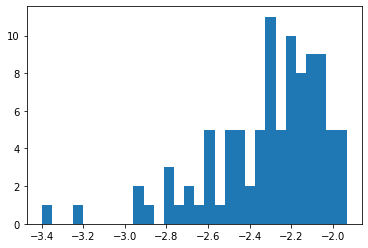

In [61]:
%matplotlib inline
plt.hist(norm.ppf(scores), bins=30)

-inf